# Breast Cancer Biomarker Discovery - ML Analysis

**Training:** 394 tumor (84%) + 74 normal (16%) = 468 samples

**Test:** 173 tumor (50%) + 173 normal (50%) = 346 samples

**Process:**
-  Batch correction applied INSIDE each CV fold (to avoid data leakage)
-  SMOTE applied ONCE per fold
-  Feature selection and model training on consistent data
-  5 models: Logistic Regression, SVM, Random Forest, GBM, ANN

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Try to import SMOTE
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
    print('SMOTE available!')
except ImportError:
    SMOTE_AVAILABLE = False
    print('Warning: imblearn not installed. Install with: pip install imbalanced-learn')
    print('Proceeding without SMOTE (using class_weight instead)')

print('\nReady!')

SMOTE available!

Ready!


## Step 1: Load Data

Training: 394 tumor + 74 normal = 468 samples (Imbalanced 5.3:1)

In [2]:
# Load data
df = pd.read_csv('../data/processed/imputed_gene_expression_Training Dataset.csv', index_col=0)
X = df.drop('label', axis=1)
y = df['label']

print(f'Training Data:')
print(f'  Total samples: {len(y)}')
print(f'  Tumor: {sum(y==1)} ({sum(y==1)/len(y)*100:.1f}%)')
print(f'  Normal: {sum(y==0)} ({sum(y==0)/len(y)*100:.1f}%)')
print(f'  Ratio: {sum(y==1)/sum(y==0):.1f}:1 (Imbalanced!)')
print(f'  Genes: {X.shape[1]}')

# Create batch info for use inside CV (no correction yet - prevents data leakage!)
batches = []
for idx in X.index:
    gsm = str(idx).upper()
    if 'GSM593' in gsm: batches.append('GSE24124')
    elif 'GSM810' in gsm: batches.append('GSE32641')
    elif 'GSM889' in gsm: batches.append('GSE36295')
    elif 'GSM1045' in gsm: batches.append('GSE42568')
    elif 'GSM1298' in gsm: batches.append('GSE53752')
    else: batches.append('Other')

batch_df = pd.Series(batches, index=X.index)
print(f'\nBatches: {dict(batch_df.value_counts())}')

Training Data:
  Total samples: 468
  Tumor: 394 (84.2%)
  Normal: 74 (15.8%)
  Ratio: 5.3:1 (Imbalanced!)
  Genes: 1854

Batches: {'GSE24124': np.int64(194), 'Other': np.int64(153), 'GSE42568': np.int64(121)}


## Step 2: NESTED CV with SMOTE (NO DATA LEAKAGE)

**Steps:**
1.  Batch correction applied INSIDE each CV fold (only on training data!)
2.  SMOTE applied ONCE per fold
3.  Feature selection and model training on same SMOTE data
4.  Evaluate on original (non-SMOTE, non-batch-corrected) test data

In [3]:
# Models
models = {
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight='balanced'),
    'SVM': SVC(C=1.0, kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), alpha=0.001, max_iter=2000, random_state=42, early_stopping=True)
}

def apply_batch_correction(X_train, X_test, batch_df, train_idx, test_idx):
    """
    Apply batch correction ONLY on training data, then apply same correction to test.
    This prevents data leakage from test to training.
    """
    X_train_corr = X_train.copy()
    X_test_corr = X_test.copy()
    
    # Calculate batch means from training data ONLY
    train_batches = batch_df.iloc[train_idx]
    batch_means = {}
    
    for batch in train_batches.unique():
        mask = train_batches == batch
        batch_means[batch] = X_train_corr.loc[mask].mean()
    
    # Apply correction to training data
    for batch in train_batches.unique():
        mask = train_batches == batch
        X_train_corr.loc[mask] = X_train_corr.loc[mask] - batch_means[batch]
    
    # Apply correction to test data using training batch means
    test_batches = batch_df.iloc[test_idx]
    for batch in test_batches.unique():
        if batch in batch_means:
            mask = test_batches == batch
            X_test_corr.loc[mask] = X_test_corr.loc[mask] - batch_means[batch]
    
    return X_train_corr, X_test_corr

# Outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {name: {'accuracy': [], 'auroc': [], 'f1': [], 'sens': [], 'spec': [], 'y_true': [], 'y_prob': []} for name in models}
selected_genes_per_fold = []

print('Running Nested CV with SMOTE (CORRECTED - No Data Leakage)...')
print('='*70)

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f'Fold {fold}/5...')
    
    # Split data
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train_raw, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f'  Original: {len(y_train_raw)} train, {len(y_test)} test')
    print(f'  Train distribution: Tumor={sum(y_train_raw)}, Normal={sum(y_train_raw==0)}')
    
    # STEP 1: Apply batch correction INSIDE the fold (NO LEAKAGE!)
    X_train_corr, X_test_corr = apply_batch_correction(
        X_train_raw, X_test_raw, batch_df, train_idx, test_idx
    )
    print(f'  Batch correction applied (training batches only)')
    
    # STEP 2: Apply SMOTE to training data ONLY (NO LEAKAGE!)
    if SMOTE_AVAILABLE:
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train_corr, y_train_raw)
        print(f'  After SMOTE: {len(y_train_smote)} samples (balanced)')
    else:
        X_train_smote, y_train_smote = X_train_corr, y_train_raw
        print(f'  No SMOTE: using class weights')
    
    # STEP 3: Feature selection on SMOTE-balanced training data
    scaler_select = StandardScaler()
    X_train_scaled = scaler_select.fit_transform(X_train_smote)
    
    lasso = LogisticRegressionCV(Cs=np.logspace(-3, 1, 20), cv=3, penalty='l1',
                                 solver='saga', scoring='roc_auc', max_iter=2000,
                                 random_state=42, n_jobs=-1)
    lasso.fit(X_train_scaled, y_train_smote)
    
    coef = lasso.coef_[0]
    selected_genes = X_train_corr.columns[coef != 0].tolist()
    
    if len(selected_genes) > 25:
        top_indices = np.argsort(np.abs(coef[coef != 0]))[-25:]
        selected_genes = [selected_genes[i] for i in top_indices]
    
    selected_genes_per_fold.append(selected_genes)
    print(f'  Selected {len(selected_genes)} genes')
    
    # STEP 4: Subset to selected genes and scale
    X_train_selected = X_train_smote[selected_genes]  # Use SMOTE data!
    X_test_selected = X_test_corr[selected_genes]     # No SMOTE on test!
    
    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_selected)
    X_test_s = scaler.transform(X_test_selected)
    
    # STEP 5: Train and evaluate models
    for name, model in models.items():
        model.fit(X_train_s, y_train_smote)
        y_pred = model.predict(X_test_s)
        y_prob = model.predict_proba(X_test_s)[:, 1]
        
        acc = accuracy_score(y_test, y_pred)
        auroc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        results[name]['accuracy'].append(acc)
        results[name]['auroc'].append(auroc)
        results[name]['f1'].append(f1)
        results[name]['sens'].append(tp/(tp+fn))
        results[name]['spec'].append(tn/(tn+fp))
        results[name]['y_true'].extend(y_test)
        results[name]['y_prob'].extend(y_prob)

print('\n✓ Complete!')

Running Nested CV with SMOTE (CORRECTED - No Data Leakage)...
Fold 1/5...
  Original: 374 train, 94 test
  Train distribution: Tumor=315, Normal=59
  Batch correction applied (training batches only)
  After SMOTE: 630 samples (balanced)
  Selected 25 genes
Fold 2/5...
  Original: 374 train, 94 test
  Train distribution: Tumor=315, Normal=59
  Batch correction applied (training batches only)
  After SMOTE: 630 samples (balanced)
  Selected 25 genes
Fold 3/5...
  Original: 374 train, 94 test
  Train distribution: Tumor=315, Normal=59
  Batch correction applied (training batches only)
  After SMOTE: 630 samples (balanced)
  Selected 25 genes
Fold 4/5...
  Original: 375 train, 93 test
  Train distribution: Tumor=316, Normal=59
  Batch correction applied (training batches only)
  After SMOTE: 632 samples (balanced)
  Selected 25 genes
Fold 5/5...
  Original: 375 train, 93 test
  Train distribution: Tumor=315, Normal=60
  Batch correction applied (training batches only)
  After SMOTE: 630 sa

## Step 3: Results Table

In [4]:
table = []
for name, res in results.items():
    table.append({
        'Model': name,
        'Accuracy': f"{np.mean(res['accuracy']):.3f} ± {np.std(res['accuracy']):.3f}",
        'AUROC': f"{np.mean(res['auroc']):.3f} ± {np.std(res['auroc']):.3f}",
        'F1': f"{np.mean(res['f1']):.3f} ± {np.std(res['f1']):.3f}",
        'Sensitivity': f"{np.mean(res['sens']):.3f} ± {np.std(res['sens']):.3f}",
        'Specificity': f"{np.mean(res['spec']):.3f} ± {np.std(res['spec']):.3f}"
    })

results_df = pd.DataFrame(table)

print('\n' + '='*80)
print('RESULTS with SMOTE (Nested CV - No Data Leakage)')
print('='*80)
print(results_df.to_string(index=False))
print('='*80)

print('\nExpected: 75-90% AUROC with proper methodology')
print('Test set: Balanced (173 tumor, 173 normal) for fair evaluation')


RESULTS with SMOTE (Nested CV - No Data Leakage)
              Model      Accuracy         AUROC            F1   Sensitivity   Specificity
Logistic Regression 0.987 ± 0.011 0.994 ± 0.011 0.992 ± 0.006 0.995 ± 0.006 0.945 ± 0.053
                SVM 0.991 ± 0.013 0.993 ± 0.013 0.995 ± 0.007 0.997 ± 0.005 0.958 ± 0.057
      Random Forest 0.991 ± 0.008 0.995 ± 0.009 0.995 ± 0.005 1.000 ± 0.000 0.945 ± 0.053
  Gradient Boosting 0.985 ± 0.009 0.992 ± 0.012 0.991 ± 0.005 0.997 ± 0.005 0.918 ± 0.052
                ANN 0.961 ± 0.023 0.979 ± 0.034 0.977 ± 0.014 0.964 ± 0.026 0.945 ± 0.053

Expected: 75-90% AUROC with proper methodology
Test set: Balanced (173 tumor, 173 normal) for fair evaluation


## Step 4: Save Results & Plots

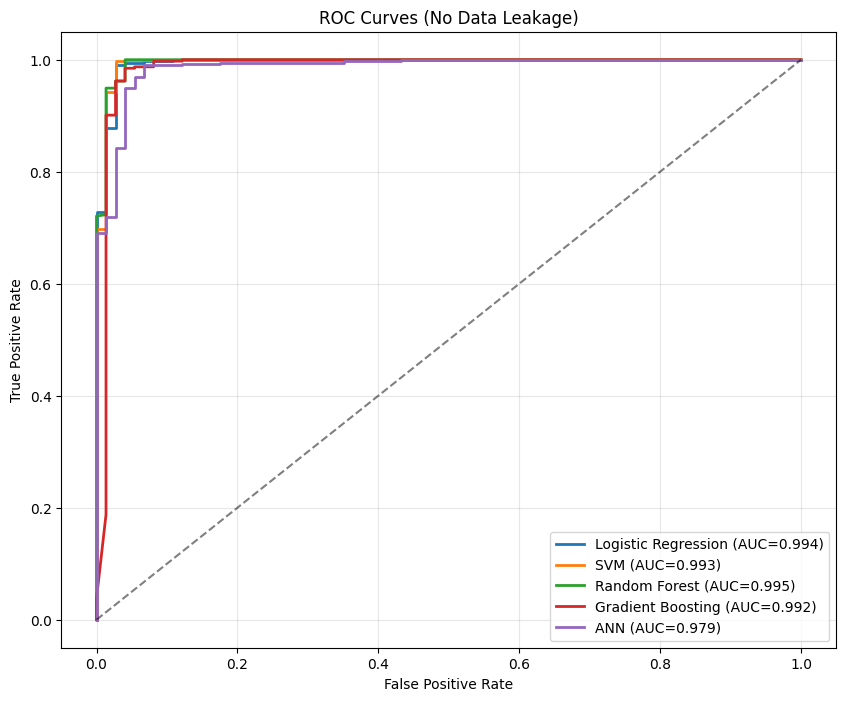


[SAVED] All results!


In [5]:
# Save table
results_df.to_csv('../results/model_results_ML_Analysis.csv', index=False)

# Get consistently selected genes
from collections import Counter
all_selected = [gene for fold_genes in selected_genes_per_fold for gene in fold_genes]
gene_counts = Counter(all_selected)
consistent_genes = [gene for gene, count in gene_counts.items() if count >= 3]

pd.DataFrame({'gene': consistent_genes, 'folds_selected': [gene_counts[g] for g in consistent_genes]}).to_csv(
    '../results/biomarkers_ML_Analysis.csv', index=False
)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(res['y_true'], res['y_prob'])
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={np.mean(res['auroc']):.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (No Data Leakage)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('../results/ROC_ML_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n[SAVED] All results!')

## Step 5: External Validation

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print("="*80)
print("EXTERNAL VALIDATION")
print("="*80)

try:
    # 1. Load external test data
    print('\n1. Loading external test data...')
    test_df = pd.read_csv('../data/processed/Test_Dataset_Preprocessed.csv', index_col=0)
    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label']
    
    print(f'   ✓ Loaded: {len(y_test)} samples')
    print(f'   Tumor: {sum(y_test==1)} ({sum(y_test==1)/len(y_test)*100:.1f}%)')
    print(f'   Normal: {sum(y_test==0)} ({sum(y_test==0)/len(y_test)*100:.1f}%)')
    print(f'   Genes: {X_test.shape[1]}')

    # 2. Get biomarkers selected during CV
    print('\n2. Getting biomarkers from CV...')
    all_selected = [gene for fold_genes in selected_genes_per_fold for gene in fold_genes]
    gene_counts = Counter(all_selected)
    final_genes = [gene for gene, count in gene_counts.items() if count >= 3]
    print(f'   Genes selected in ≥3 CV folds: {len(final_genes)}')

    # 3. Find common genes between train and test
    print('\n3. Finding common genes...')
    common_genes = [g for g in final_genes if g in X_test.columns]
    print(f'   Common genes: {len(common_genes)}')
    
    if len(common_genes) == 0:
        print(' Warning: No overlap! Using top 20 genes from training...')
        final_genes = [gene for gene, count in gene_counts.most_common(20)]
        common_genes = [g for g in final_genes if g in X_test.columns][:20]
        print(f'   Using {len(common_genes)} available genes')

    # 4. Prepare data (apply batch correction on full training data)
    print('\n4. Preparing data...')
    # Apply batch correction to full training data
    X_corrected = X.copy()
    for batch in batch_df.unique():
        mask = batch_df == batch
        X_corrected.loc[mask] = X_corrected.loc[mask] - X_corrected.loc[mask].mean()
    
    X_train_final = X_corrected[common_genes].copy()
    X_test_selected = X_test[common_genes].copy()
    
    # Handle missing values
    train_median = X_train_final.median()
    X_train_final = X_train_final.fillna(train_median)
    X_test_selected = X_test_selected.fillna(train_median)
    
    print(f'   Training: {X_train_final.shape}')
    print(f'   Test: {X_test_selected.shape}')

    # 5. Scale features
    print('\n5. Scaling features...')
    scaler_final = StandardScaler()
    X_train_s = scaler_final.fit_transform(X_train_final)
    X_test_s = scaler_final.transform(X_test_selected)

    # 6. Train best model on FULL training data
    print('\n6. Training Logistic Regression on full training data...')
    best_model = LogisticRegression(
        C=1.0, 
        max_iter=3000, 
        random_state=42, 
        class_weight='balanced'
    )
    best_model.fit(X_train_s, y)
    print('   ✓ Model trained!')

    # 7. Predict on external test
    print('\n7. Predicting on external test set...')
    y_pred = best_model.predict(X_test_s)
    y_prob = best_model.predict_proba(X_test_s)[:, 1]

    # 8. Calculate metrics
    auroc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # 9. Display results
    print('\n' + '='*80)
    print('EXTERNAL TEST RESULTS')
    print('='*80)
    print(f'AUROC:        {auroc:.3f}')
    print(f'Accuracy:     {acc:.3f}')
    print(f'Sensitivity:  {sensitivity:.3f}')
    print(f'Specificity:  {specificity:.3f}')
    print(f'\nConfusion Matrix:')
    print(f'                 Predicted')
    print(f'                 Normal  Tumor')
    print(f'Actual Normal    {tn:6d}  {fp:6d}')
    print(f'Actual Tumor     {fn:6d}  {tp:6d}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Tumor']))
    print('='*80)

    # 10. Save results
    print('\n8. Saving results...')
    results_external = pd.DataFrame({
        'Metric': ['AUROC', 'Accuracy', 'Sensitivity', 'Specificity'],
        'Value': [auroc, acc, sensitivity, specificity]
    })
    results_external.to_csv('../results/external_validation_results.csv', index=False)
    print('   ✓ Saved to: results/external_validation_results.csv')
    
except FileNotFoundError:
    print('\n❌ ERROR: Test dataset not found!')
    print('   Make sure you have: data/processed/Test_Dataset_Preprocessed.csv')
except Exception as e:
    print(f'\n❌ ERROR: {e}')
    import traceback
    traceback.print_exc()

print('='*80)

EXTERNAL VALIDATION

1. Loading external test data...
   ✓ Loaded: 346 samples
   Tumor: 173 (50.0%)
   Normal: 173 (50.0%)
   Genes: 11981

2. Getting biomarkers from CV...
   Genes selected in ≥3 CV folds: 23

3. Finding common genes...
   Common genes: 23

4. Preparing data...
   Training: (468, 23)
   Test: (346, 23)

5. Scaling features...

6. Training Logistic Regression on full training data...
   ✓ Model trained!

7. Predicting on external test set...

EXTERNAL TEST RESULTS
AUROC:        0.889
Accuracy:     0.743
Sensitivity:  0.486
Specificity:  1.000

Confusion Matrix:
                 Predicted
                 Normal  Tumor
Actual Normal       173       0
Actual Tumor         89      84

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      1.00      0.80       173
       Tumor       1.00      0.49      0.65       173

    accuracy                           0.74       346
   macro avg       0.83      0.74      0.72       

In [8]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


# Works in notebooks and scripts
if "__file__" in globals():
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
elif Path.cwd().name == "notebooks":
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path.cwd()

DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)


warnings.filterwarnings("ignore")

PROJECT_ROOT = Path(__file__).resolve().parents[1]
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


def load_inputs():
    train_df = pd.read_csv(DATA_DIR / "imputed_gene_expression_Training Dataset.csv", index_col=0)
    test_df = pd.read_csv(DATA_DIR / "Test_Dataset_Preprocessed.csv", index_col=0)
    biomarkers = pd.read_csv(RESULTS_DIR / "biomarkers_ML_Analysis.csv")

    x_train = train_df.drop(columns=["label"])
    y_train = train_df["label"].astype(int)

    drop_cols = [c for c in ["label", "DiseaseType", "Dataset"] if c in test_df.columns]
    x_test = test_df.drop(columns=drop_cols)
    y_test = test_df["label"].astype(int)

    return x_train, y_train, x_test, y_test, biomarkers


def choose_threshold(y_true, y_prob, min_specificity=0.85):
    thresholds = np.linspace(0.05, 0.95, 181)
    best = None

    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if spec >= min_specificity:
            score = (sens, f1, spec)
            if best is None or score > best[0]:
                best = (score, thr)

    if best is not None:
        return float(best[1])

    best_j, best_thr = -1.0, 0.5
    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        j = sens + spec - 1.0
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)


def tune_threshold_with_cv(x_train, y_train, genes):
    x = x_train[genes].copy()
    med = x.median()
    x = x.fillna(med)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_prob = np.zeros(len(y_train), dtype=float)

    for tr_idx, val_idx in cv.split(x, y_train):
        x_tr, x_val = x.iloc[tr_idx], x.iloc[val_idx]
        y_tr = y_train.iloc[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_val_s = scaler.transform(x_val)

        model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
        model.fit(x_tr_s, y_tr)
        oof_prob[val_idx] = model.predict_proba(x_val_s)[:, 1]

    return choose_threshold(y_train.values, oof_prob, min_specificity=0.85)


def fit_predict_prob(x_train, y_train, x_test, genes):
    x_tr = x_train[genes].copy()
    x_te = x_test[genes].copy()

    med = x_tr.median()
    x_tr = x_tr.fillna(med)
    x_te = x_te.fillna(med)

    scaler = StandardScaler()
    x_tr_s = scaler.fit_transform(x_tr)
    x_te_s = scaler.transform(x_te)

    model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
    model.fit(x_tr_s, y_train)
    return model.predict_proba(x_te_s)[:, 1]


def metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return {
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Sensitivity": sens,
        "Specificity": spec,
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
        "TP": int(tp),
    }


def save_confusion_and_report(y_true, y_prob, threshold, prefix):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(cm, index=["Actual_Normal", "Actual_Tumor"], columns=["Pred_Normal", "Pred_Tumor"])
    cm_df.to_csv(RESULTS_DIR / f"{prefix}_confusion_matrix.csv")

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred Normal", "Pred Tumor"])
    ax.set_yticklabels(["Actual Normal", "Actual Tumor"])
    ax.set_title(f"Confusion Matrix ({prefix})")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(RESULTS_DIR / f"{prefix}_confusion_matrix.png", dpi=300)
    plt.close(fig)

    report = classification_report(y_true, y_pred, target_names=["Normal", "Tumor"], output_dict=True, zero_division=0)
    pd.DataFrame(report).T.to_csv(RESULTS_DIR / f"{prefix}_classification_report.csv")


def run_pathway_enrichment(genes):
    out_dir = RESULTS_DIR / "pathway_enrichment"
    out_dir.mkdir(parents=True, exist_ok=True)
    try:
        import gseapy as gp

        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=["GO_Biological_Process_2023", "KEGG_2021_Human"],
            organism="Human",
            outdir=str(out_dir),
            no_plot=True,
            cutoff=1.0,
        )
        if hasattr(enr, "results") and enr.results is not None and len(enr.results) > 0:
            enr.results.to_csv(out_dir / "enrichment_results.csv", index=False)
            enr.results.head(25).to_csv(out_dir / "enrichment_top25.csv", index=False)
        else:
            (out_dir / "enrichment_status.txt").write_text("Enrichment ran but returned no terms.", encoding="utf-8")
    except Exception as exc:
        (out_dir / "enrichment_status.txt").write_text(
            f"Pathway enrichment not completed. Reason: {exc}", encoding="utf-8"
        )


def validate_leave_one_dataset_out(full_genes):
    train_pre = pd.read_csv(DATA_DIR / "Training_Dataset_Preprocessed.csv", index_col=0)
    if "Dataset" not in train_pre.columns:
        return
    datasets = sorted(train_pre["Dataset"].dropna().unique().tolist())
    genes = [g for g in full_genes if g in train_pre.columns]
    if not genes:
        return

    rows = []
    for holdout in datasets:
        tr = train_pre[train_pre["Dataset"] != holdout].copy()
        te = train_pre[train_pre["Dataset"] == holdout].copy()

        y_tr = tr["label"].astype(int)
        y_te = te["label"].astype(int)
        x_tr = tr[genes].copy()
        x_te = te[genes].copy()

        med = x_tr.median()
        x_tr = x_tr.fillna(med)
        x_te = x_te.fillna(med)

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_te)

        model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
        model.fit(x_tr_s, y_tr)

        prob = model.predict_proba(x_te_s)[:, 1]
        pred = (prob >= 0.5).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else np.nan
        spec = tn / (tn + fp) if (tn + fp) else np.nan

        rows.append(
            {
                "Holdout_Dataset": holdout,
                "Samples": len(te),
                "Tumor": int((y_te == 1).sum()),
                "Normal": int((y_te == 0).sum()),
                "AUROC": roc_auc_score(y_te, prob),
                "Accuracy": accuracy_score(y_te, pred),
                "Sensitivity": sens,
                "Specificity": spec,
            }
        )

    pd.DataFrame(rows).sort_values("Holdout_Dataset").to_csv(RESULTS_DIR / "leave_one_dataset_out_validation.csv", index=False)


def main():
    x_train, y_train, x_test, y_test, biomarkers = load_inputs()

    ranked = biomarkers.sort_values(["folds_selected", "gene"], ascending=[False, True])["gene"].tolist()
    consistent = biomarkers[biomarkers["folds_selected"] >= 3].sort_values(
        ["folds_selected", "gene"], ascending=[False, True]
    )["gene"].tolist()
    if not consistent:
        consistent = ranked

    def panel(genes, n):
        common = [g for g in genes if g in x_train.columns and g in x_test.columns]
        return common if n is None else common[:n]

    full_panel = panel(consistent, None)
    top10_panel = panel(ranked, 10)
    top5_panel = panel(ranked, 5)

    if not full_panel:
        raise RuntimeError("No overlapping genes found between train and test for evaluation panels.")

    tuned_threshold = tune_threshold_with_cv(x_train, y_train, full_panel)

    panels = {"top5": top5_panel, "top10": top10_panel, "full": full_panel}
    rows = []
    pr_curves = {}

    for name, genes in panels.items():
        if not genes:
            continue
        prob = fit_predict_prob(x_train, y_train, x_test, genes)
        thr = tuned_threshold if name == "full" else 0.5
        m = metrics(y_test.values, prob, thr)
        rows.append({"Panel": name, "Genes": len(genes), "Threshold": thr, **m})

        precision, recall, _ = precision_recall_curve(y_test.values, prob)
        pr_curves[name] = (recall, precision, m["AUPRC"])

        if name == "full":
            save_confusion_and_report(y_test.values, prob, 0.5, "external_full_threshold_0_5")
            save_confusion_and_report(y_test.values, prob, tuned_threshold, "external_full_threshold_tuned")

    pd.DataFrame(rows).sort_values("Panel").to_csv(RESULTS_DIR / "panel_comparison_external.csv", index=False)

    fig, ax = plt.subplots(figsize=(7, 5))
    for name, (recall, precision, auprc) in pr_curves.items():
        ax.plot(recall, precision, linewidth=2, label=f"{name} (AUPRC={auprc:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("External Precision-Recall Curves")
    ax.legend(loc="best")
    ax.grid(alpha=0.2)
    fig.tight_layout()
    fig.savefig(RESULTS_DIR / "precision_recall_external.png", dpi=300)
    plt.close(fig)

    pd.DataFrame(
        {
            "Panel": ["full"],
            "Tuned_Threshold": [tuned_threshold],
            "Threshold_Method": ["maximize sensitivity with specificity >= 0.85 on 5-fold CV"],
        }
    ).to_csv(RESULTS_DIR / "threshold_tuning_summary.csv", index=False)

    run_pathway_enrichment(full_panel)
    validate_leave_one_dataset_out(full_panel)

    print("Saved extended evaluation outputs to results/.")


if __name__ == "__main__":
    main()


PROJECT_ROOT: c:\Users\mmsid\Downloads\Breast-Cancer-Biomarkers-Discover-Using-ML-main


NameError: name '__file__' is not defined

## Extended Evaluation Outputs

In [9]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

if "__file__" in globals():
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
elif Path.cwd().name == "notebooks":
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path.cwd()

DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)


def load_inputs():
    train_df = pd.read_csv(DATA_DIR / "imputed_gene_expression_Training Dataset.csv", index_col=0)
    test_df = pd.read_csv(DATA_DIR / "Test_Dataset_Preprocessed.csv", index_col=0)
    biomarkers = pd.read_csv(RESULTS_DIR / "biomarkers_ML_Analysis.csv")

    x_train = train_df.drop(columns=["label"])
    y_train = train_df["label"].astype(int)

    drop_cols = [c for c in ["label", "DiseaseType", "Dataset"] if c in test_df.columns]
    x_test = test_df.drop(columns=drop_cols)
    y_test = test_df["label"].astype(int)

    return x_train, y_train, x_test, y_test, biomarkers


def choose_threshold(y_true, y_prob, min_specificity=0.85):
    thresholds = np.linspace(0.05, 0.95, 181)
    best = None

    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if spec >= min_specificity:
            score = (sens, f1, spec)
            if best is None or score > best[0]:
                best = (score, thr)

    if best is not None:
        return float(best[1])

    best_j, best_thr = -1.0, 0.5
    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        j = sens + spec - 1.0
        if j > best_j:
            best_j, best_thr = j, thr
    return float(best_thr)


def tune_threshold_with_cv(x_train, y_train, genes):
    x = x_train[genes].copy()
    med = x.median()
    x = x.fillna(med)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_prob = np.zeros(len(y_train), dtype=float)

    for tr_idx, val_idx in cv.split(x, y_train):
        x_tr, x_val = x.iloc[tr_idx], x.iloc[val_idx]
        y_tr = y_train.iloc[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_val_s = scaler.transform(x_val)

        model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
        model.fit(x_tr_s, y_tr)
        oof_prob[val_idx] = model.predict_proba(x_val_s)[:, 1]

    return choose_threshold(y_train.values, oof_prob, min_specificity=0.85)


def fit_predict_prob(x_train, y_train, x_test, genes):
    x_tr = x_train[genes].copy()
    x_te = x_test[genes].copy()

    med = x_tr.median()
    x_tr = x_tr.fillna(med)
    x_te = x_te.fillna(med)

    scaler = StandardScaler()
    x_tr_s = scaler.fit_transform(x_tr)
    x_te_s = scaler.transform(x_te)

    model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
    model.fit(x_tr_s, y_train)
    return model.predict_proba(x_te_s)[:, 1]


def metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return {
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Sensitivity": sens,
        "Specificity": spec,
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
        "TP": int(tp),
    }


def save_confusion_and_report(y_true, y_prob, threshold, prefix):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(cm, index=["Actual_Normal", "Actual_Tumor"], columns=["Pred_Normal", "Pred_Tumor"])
    cm_df.to_csv(RESULTS_DIR / f"{prefix}_confusion_matrix.csv")

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred Normal", "Pred Tumor"])
    ax.set_yticklabels(["Actual Normal", "Actual Tumor"])
    ax.set_title(f"Confusion Matrix ({prefix})")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(RESULTS_DIR / f"{prefix}_confusion_matrix.png", dpi=300)
    plt.close(fig)

    report = classification_report(y_true, y_pred, target_names=["Normal", "Tumor"], output_dict=True, zero_division=0)
    pd.DataFrame(report).T.to_csv(RESULTS_DIR / f"{prefix}_classification_report.csv")


def run_pathway_enrichment(genes):
    out_dir = RESULTS_DIR / "pathway_enrichment"
    out_dir.mkdir(parents=True, exist_ok=True)
    try:
        import gseapy as gp

        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=["GO_Biological_Process_2023", "KEGG_2021_Human"],
            organism="Human",
            outdir=str(out_dir),
            no_plot=True,
            cutoff=1.0,
        )
        if hasattr(enr, "results") and enr.results is not None and len(enr.results) > 0:
            enr.results.to_csv(out_dir / "enrichment_results.csv", index=False)
            enr.results.head(25).to_csv(out_dir / "enrichment_top25.csv", index=False)
        else:
            (out_dir / "enrichment_status.txt").write_text("Enrichment ran but returned no terms.", encoding="utf-8")
    except Exception as exc:
        (out_dir / "enrichment_status.txt").write_text(
            f"Pathway enrichment not completed. Reason: {exc}", encoding="utf-8"
        )


def validate_leave_one_dataset_out(full_genes):
    train_pre = pd.read_csv(DATA_DIR / "Training_Dataset_Preprocessed.csv", index_col=0)
    if "Dataset" not in train_pre.columns:
        return
    datasets = sorted(train_pre["Dataset"].dropna().unique().tolist())
    genes = [g for g in full_genes if g in train_pre.columns]
    if not genes:
        return

    rows = []
    for holdout in datasets:
        tr = train_pre[train_pre["Dataset"] != holdout].copy()
        te = train_pre[train_pre["Dataset"] == holdout].copy()

        y_tr = tr["label"].astype(int)
        y_te = te["label"].astype(int)
        x_tr = tr[genes].copy()
        x_te = te[genes].copy()

        med = x_tr.median()
        x_tr = x_tr.fillna(med)
        x_te = x_te.fillna(med)

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_te)

        model = LogisticRegression(C=1.0, max_iter=3000, random_state=42, class_weight="balanced")
        model.fit(x_tr_s, y_tr)

        prob = model.predict_proba(x_te_s)[:, 1]
        pred = (prob >= 0.5).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else np.nan
        spec = tn / (tn + fp) if (tn + fp) else np.nan

        rows.append(
            {
                "Holdout_Dataset": holdout,
                "Samples": len(te),
                "Tumor": int((y_te == 1).sum()),
                "Normal": int((y_te == 0).sum()),
                "AUROC": roc_auc_score(y_te, prob),
                "Accuracy": accuracy_score(y_te, pred),
                "Sensitivity": sens,
                "Specificity": spec,
            }
        )

    pd.DataFrame(rows).sort_values("Holdout_Dataset").to_csv(RESULTS_DIR / "leave_one_dataset_out_validation.csv", index=False)


def main():
    x_train, y_train, x_test, y_test, biomarkers = load_inputs()

    ranked = biomarkers.sort_values(["folds_selected", "gene"], ascending=[False, True])["gene"].tolist()
    consistent = biomarkers[biomarkers["folds_selected"] >= 3].sort_values(
        ["folds_selected", "gene"], ascending=[False, True]
    )["gene"].tolist()
    if not consistent:
        consistent = ranked

    def panel(genes, n):
        common = [g for g in genes if g in x_train.columns and g in x_test.columns]
        return common if n is None else common[:n]

    full_panel = panel(consistent, None)
    top10_panel = panel(ranked, 10)
    top5_panel = panel(ranked, 5)

    if not full_panel:
        raise RuntimeError("No overlapping genes found between train and test for evaluation panels.")

    tuned_threshold = tune_threshold_with_cv(x_train, y_train, full_panel)

    panels = {"top5": top5_panel, "top10": top10_panel, "full": full_panel}
    rows = []
    pr_curves = {}

    for name, genes in panels.items():
        if not genes:
            continue
        prob = fit_predict_prob(x_train, y_train, x_test, genes)
        thr = tuned_threshold if name == "full" else 0.5
        m = metrics(y_test.values, prob, thr)
        rows.append({"Panel": name, "Genes": len(genes), "Threshold": thr, **m})

        precision, recall, _ = precision_recall_curve(y_test.values, prob)
        pr_curves[name] = (recall, precision, m["AUPRC"])

        if name == "full":
            save_confusion_and_report(y_test.values, prob, 0.5, "external_full_threshold_0_5")
            save_confusion_and_report(y_test.values, prob, tuned_threshold, "external_full_threshold_tuned")

    pd.DataFrame(rows).sort_values("Panel").to_csv(RESULTS_DIR / "panel_comparison_external.csv", index=False)

    fig, ax = plt.subplots(figsize=(7, 5))
    for name, (recall, precision, auprc) in pr_curves.items():
        ax.plot(recall, precision, linewidth=2, label=f"{name} (AUPRC={auprc:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("External Precision-Recall Curves")
    ax.legend(loc="best")
    ax.grid(alpha=0.2)
    fig.tight_layout()
    fig.savefig(RESULTS_DIR / "precision_recall_external.png", dpi=300)
    plt.close(fig)

    pd.DataFrame(
        {
            "Panel": ["full"],
            "Tuned_Threshold": [tuned_threshold],
            "Threshold_Method": ["maximize sensitivity with specificity >= 0.85 on 5-fold CV"],
        }
    ).to_csv(RESULTS_DIR / "threshold_tuning_summary.csv", index=False)

    run_pathway_enrichment(full_panel)
    validate_leave_one_dataset_out(full_panel)

    print("Saved extended evaluation outputs to results/.")


main()


PROJECT_ROOT: c:\Users\mmsid\Downloads\Breast-Cancer-Biomarkers-Discover-Using-ML-main
Saved extended evaluation outputs to results/.


## Pathway Enrichment PNG Plots

In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use existing PROJECT_ROOT if present; fallback for notebook execution
if "PROJECT_ROOT" in globals():
    project_root = PROJECT_ROOT
elif Path.cwd().name == "notebooks":
    project_root = Path.cwd().parent
else:
    project_root = Path.cwd()

enrich_file = project_root / "results" / "pathway_enrichment" / "enrichment_results.csv"
out_dir = project_root / "results" / "pathway_enrichment"
out_dir.mkdir(parents=True, exist_ok=True)

if not enrich_file.exists():
    raise FileNotFoundError(f"Enrichment file not found: {enrich_file}")

df = pd.read_csv(enrich_file)
if df.empty:
    raise ValueError("enrichment_results.csv is empty")

# Robust score transform for plotting
p_col = "Adjusted P-value" if "Adjusted P-value" in df.columns else "P-value"
df = df[df[p_col].notna()].copy()
df["plot_score"] = -np.log10(df[p_col].clip(lower=1e-300))

def save_plot(gene_set_name, out_png, top_n=15):
    sub = df[df["Gene_set"] == gene_set_name].copy()
    if sub.empty:
        print(f"No rows for {gene_set_name}; skipping {out_png.name}")
        return

    sub = sub.sort_values(p_col, ascending=True).head(top_n)
    sub = sub.sort_values("plot_score", ascending=True)

    plt.figure(figsize=(10, max(6, 0.45 * len(sub))))
    plt.barh(sub["Term"], sub["plot_score"], color="#2E6F95")
    plt.xlabel(f"-log10({p_col})")
    plt.ylabel("Pathway")
    plt.title(f"Top {len(sub)} {gene_set_name} Enriched Terms")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()
    print(f"Saved: {out_png}")

save_plot("GO_Biological_Process_2023", out_dir / "GO_enrichment_top_terms.png", top_n=15)
save_plot("KEGG_2021_Human", out_dir / "KEGG_enrichment_top_terms.png", top_n=15)


Saved: c:\Users\mmsid\Downloads\Breast-Cancer-Biomarkers-Discover-Using-ML-main\results\pathway_enrichment\GO_enrichment_top_terms.png
Saved: c:\Users\mmsid\Downloads\Breast-Cancer-Biomarkers-Discover-Using-ML-main\results\pathway_enrichment\KEGG_enrichment_top_terms.png
